In [1]:
!pip install python-levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 68.4 MB/s eta 0:00:00:00:01


In [2]:
import os
import sys
import pandas as pd
import numpy as np
import Levenshtein as lev
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
import datetime
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

from tqdm import tqdm

cuda = torch.cuda.is_available()

print(cuda, sys.version)

device = torch.device("cuda" if cuda else "cpu")
num_workers = 4 if cuda else 0
print("Cuda = "+str(cuda)+" with num_workers = "+str(num_workers))
np.random.seed(42)
torch.manual_seed(42)

True 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
Cuda = True with num_workers = 4


In [3]:
feature_df = pd.read_csv('/kaggle/input/aic-data/train.csv', skiprows=0, nrows=50700)

In [4]:
feature_df

,audio,transcript
0,train_sample_0,على إنها عار في الوقت اللي كانت بتتعامل مع أخو...
1,train_sample_1,فأكيد ربنا عوضهم خير هو الراجل بيبقى ليه إختيا...
2,train_sample_2,زي دول كتيره بنشوفها النهارده في العالم وأصبحت...
3,train_sample_3,يعني مين اللي بيحط شروطها يعني أنا شايفه إني م...
4,train_sample_4,والله هي الموضوع مش كليب خلي بالك ولا أغنيه ال...
...,...,...
50695,train_sample_50695,و عندنا استعداد نستخدم طاقه صديقه للبيئه طب ال...
50696,train_sample_50696,لو عملت حاجه خير هتتردلي خير طبعا طيب ما في نا...
50697,train_sample_50697,كذبت والله يا عدو الله الذي قلت لا أحياء كلهم ...
50698,train_sample_50698,يعني متحولوش تترددوا في إن إنتو تحافظوا على صح...


In [5]:
feature_df['audio'] = '/kaggle/input/aic-data/train/' + feature_df['audio'] + '.wav'

In [6]:
import pandas as pd

feature_df['transcript'] = feature_df['transcript'].astype(str)

all_text = " ".join(feature_df['transcript'])

unique_chars = list(set(all_text))

print("Unique characters in the DataFrame:", unique_chars)
len(unique_chars)

Unique characters in the DataFrame: ['ح', 'ب', 'o', 'ٱ', 'ز', 'ن', 'ى', 'ؤ', '[', 'g', 'خ', '⁇', 'v', 'n', 'س', ' ', 'ض', 'l', '،', 'h', 'ل', 'ه', 'ط', 'ي', 'ث', 'e', 'ئ', '<', 'ذ', 'r', 'أ', 'و', 'آ', 'u', 'i', 'ق', 'ڨ', 'ف', 'ع', 'ش', 'ك', 'ر', 'ت', '=', 'د', 'م', 'ِ', 'غ', 'ا', '>', 'ً', 'ظ', 'ة', 'a', 'ج', 'ص', 'p', 'f', '÷', 'ء', '١', 'چ', 'إ']


63

In [7]:
import re

chars_to_ignore_regex = r'[\,\?\.\!\-\;\:\"\“\%\‘\”\�]'

additional_chars_to_ignore = ['>', ']', 'l', 'ـ', '>', '<', ',', 'i', 'f', 'o', 'e', 'g', 'h', 'f', 'p', '=', ']', '[', '?', '??', 'r', 'n', 'v', 'u', '÷']

escaped_chars_to_ignore = [re.escape(char) for char in additional_chars_to_ignore]

all_chars_to_ignore = escaped_chars_to_ignore + re.findall(r'\w', chars_to_ignore_regex)

combined_chars_to_ignore_regex = re.compile('|'.join(all_chars_to_ignore))

feature_df["transcript"] = feature_df["transcript"].apply(lambda x: re.sub(combined_chars_to_ignore_regex, '', x).lower() + " ")

print(feature_df.tail(10))

                                                   audio  \
50690  /kaggle/input/aic-data/train/train_sample_5069...   
50691  /kaggle/input/aic-data/train/train_sample_5069...   
50692  /kaggle/input/aic-data/train/train_sample_5069...   
50693  /kaggle/input/aic-data/train/train_sample_5069...   
50694  /kaggle/input/aic-data/train/train_sample_5069...   
50695  /kaggle/input/aic-data/train/train_sample_5069...   
50696  /kaggle/input/aic-data/train/train_sample_5069...   
50697  /kaggle/input/aic-data/train/train_sample_5069...   
50698  /kaggle/input/aic-data/train/train_sample_5069...   
50699  /kaggle/input/aic-data/train/train_sample_5069...   

                                              transcript  
50690  الأسر محدودة الدخل أولا بدل ما كنا بنتعامل مع ...  
50691  إله بيتودد لعباده أه بيتدلل لعباده ده ربنا بيق...  
50692  على سطح الأرض في طبقات الجو العليا بتبعت كل ال...  
50693  تحطه في حته بيتقال عليهم كده في الوسط بتاعنا د...  
50694   عندك عندك حق هو المزارع لأنه فيه وسط

In [8]:
import pandas as pd

all_text = " ".join(feature_df['transcript'])

unique_chars = list(set(all_text))

print("Unique characters in the DataFrame:")
print(unique_chars)
len(unique_chars)

Unique characters in the DataFrame:
['ح', 'ب', 'ٱ', 'ز', 'ن', 'ى', 'ؤ', 'خ', '⁇', 'س', ' ', 'ض', '،', 'ل', 'ه', 'ط', 'ي', 'ث', 'ئ', 'ذ', 'أ', 'و', 'آ', 'ق', 'ڨ', 'ف', 'ع', 'ش', 'ك', 'ر', 'ت', 'د', 'م', 'ِ', 'غ', 'ا', 'ً', 'ظ', 'ة', 'a', 'ج', 'ص', '١', 'ء', 'چ', 'إ']


46

In [9]:
feature_df.to_csv('feature_data.csv', index=False)

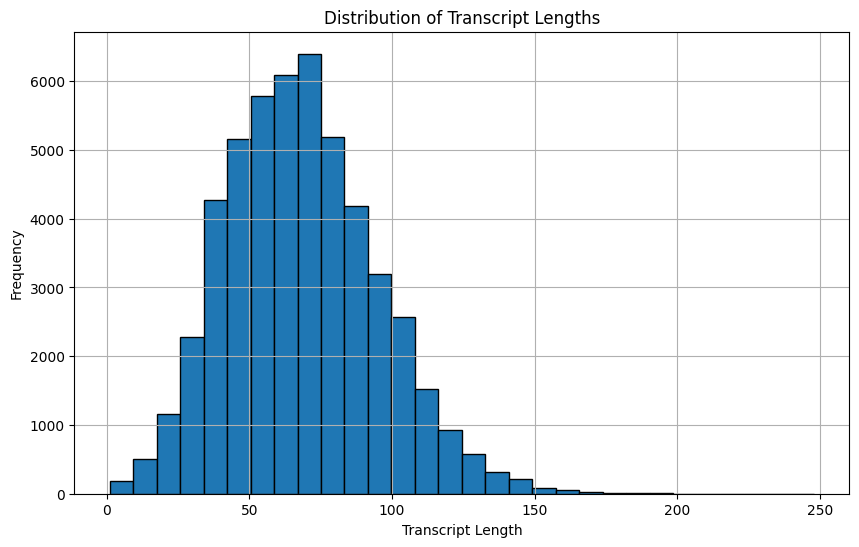

In [10]:
df = pd.read_csv('feature_data.csv')

df['transcript_length'] = df['transcript'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df['transcript_length'], bins=30, edgecolor='black')
plt.xlabel('Transcript Length')
plt.ylabel('Frequency')
plt.title('Distribution of Transcript Lengths')
plt.grid(True)
plt.show()

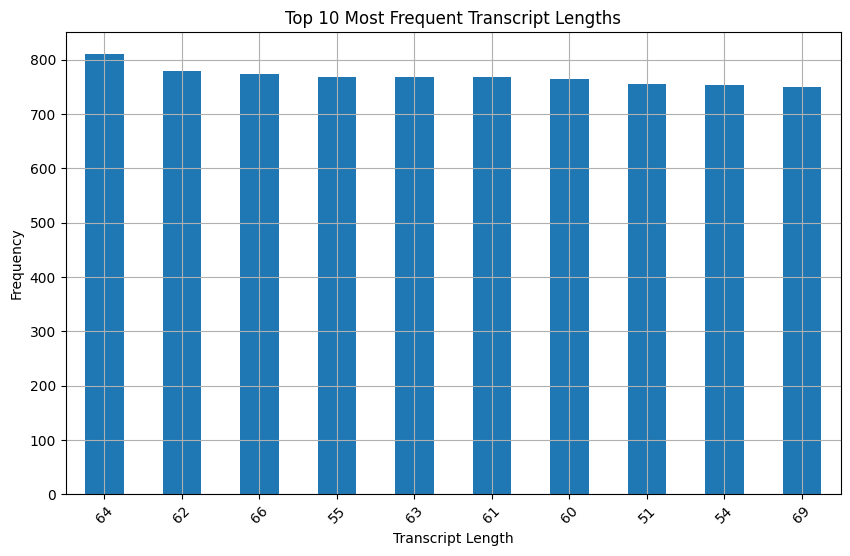

In [11]:
df = pd.read_csv('feature_data.csv')

df['transcript_length'] = df['transcript'].apply(len)

length_counts = df['transcript_length'].value_counts()

plt.figure(figsize=(10, 6))
length_counts.head(10).plot(kind='bar')
plt.xlabel('Transcript Length')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Transcript Lengths')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [12]:
LETTER_LIST = ['<sos>' ,'غ', 'ب', '⁇', 'ظ', 'ا', 'چ', 'ق', 'ح', 'ث', 'ً', '١', 'س', 'خ', 'ه', 'ن', 'ل', 'ء', 'ر', 'ص', 'ف', 'ى', 'ِ', 'د', 'ض', 'آ', 'ج', 'ئ', 'و', 'ز', 'ذ', 'ش', '،', 'ة', 'أ', 'a', 'إ', 'ؤ', 'ي', 'ك', 'م', ' ', 'ڨ', 'ٱ', 'ت', 'ط', 'ع' ,'<eos>']

In [13]:
def create_dictionaries(letter_list):
    '''
    Create dictionaries for letter2index and index2letter transformations
    based on LETTER_LIST

    Args:
        letter_list: LETTER_LIST

    Return:
        letter2index: Dictionary mapping from letters to indices
        index2letter: Dictionary mapping from indices to letters
    '''
    letter2index = dict()
    index2letter = dict()

    for i in range(len(letter_list)):
        letter2index[letter_list[i]] = i
        index2letter[i] = letter_list[i]

    # print(letter2index)
    # print(index2letter)

    return letter2index, index2letter
    

def transform_index_to_letter(batch_indices):
    '''
    Transforms numerical index input to string output by converting each index 
    to its corresponding letter from LETTER_LIST

    Args:
        batch_indices: List of indices from LETTER_LIST with the shape of (N, )
    
    Return:
        transcripts: List of converted string transcripts. This would be a list with a length of N
    '''
    transcripts = []
    for i in batch_indices:
        transcripts.append(LETTER_LIST[i])
    return transcripts
        
# Create the letter2index and index2letter dictionary
letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [14]:
print(letter2index)
print(index2letter)

{'<sos>': 0, 'غ': 1, 'ب': 2, '⁇': 3, 'ظ': 4, 'ا': 5, 'چ': 6, 'ق': 7, 'ح': 8, 'ث': 9, 'ً': 10, '١': 11, 'س': 12, 'خ': 13, 'ه': 14, 'ن': 15, 'ل': 16, 'ء': 17, 'ر': 18, 'ص': 19, 'ف': 20, 'ى': 21, 'ِ': 22, 'د': 23, 'ض': 24, 'آ': 25, 'ج': 26, 'ئ': 27, 'و': 28, 'ز': 29, 'ذ': 30, 'ش': 31, '،': 32, 'ة': 33, 'أ': 34, 'a': 35, 'إ': 36, 'ؤ': 37, 'ي': 38, 'ك': 39, 'م': 40, ' ': 41, 'ڨ': 42, 'ٱ': 43, 'ت': 44, 'ط': 45, 'ع': 46, '<eos>': 47}
{0: '<sos>', 1: 'غ', 2: 'ب', 3: '⁇', 4: 'ظ', 5: 'ا', 6: 'چ', 7: 'ق', 8: 'ح', 9: 'ث', 10: 'ً', 11: '١', 12: 'س', 13: 'خ', 14: 'ه', 15: 'ن', 16: 'ل', 17: 'ء', 18: 'ر', 19: 'ص', 20: 'ف', 21: 'ى', 22: 'ِ', 23: 'د', 24: 'ض', 25: 'آ', 26: 'ج', 27: 'ئ', 28: 'و', 29: 'ز', 30: 'ذ', 31: 'ش', 32: '،', 33: 'ة', 34: 'أ', 35: 'a', 36: 'إ', 37: 'ؤ', 38: 'ي', 39: 'ك', 40: 'م', 41: ' ', 42: 'ڨ', 43: 'ٱ', 44: 'ت', 45: 'ط', 46: 'ع', 47: '<eos>'}


In [35]:
feature_df2 = pd.read_csv('/kaggle/input/aic-data/adapt.csv')
feature_df2['audio'] = '/kaggle/input/aic-data/adapt/' + feature_df2['audio'] + '.wav'

In [36]:
class LibriSamples(Dataset):

    def __init__(self, data, letter_list):
        self.data = data
        self.LETTER_LIST = letter_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ind):
        audio_path = self.data.iloc[ind]['audio']
        transcript = self.data.iloc[ind]['transcript']

        y, sr = librosa.load(audio_path, sr=16000)

        #target_length = 192000
        #y = np.pad(y, (0, target_length - len(y)), 'constant')

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc = (mfcc - np.mean(mfcc, axis=0)) / np.std(mfcc, axis=0)
        
        X_data = mfcc.T
        
        label = [self.LETTER_LIST.index(yy) for yy in transcript]
        #label_padded = label + [0] * (210 - len(label))  # Padding to length 210
        Yy = torch.tensor(label).long()

        return torch.tensor(X_data, dtype=torch.float32), Yy
    
    
    @staticmethod
    def collate_fn(batch):
        batch_x = [x for x, y in batch]
        batch_y = [y for x, y in batch]

        batch_x_pad = pad_sequence(batch_x, batch_first=True, padding_value=0)
        lengths_x = [len(x) for x in batch_x]

        batch_y_pad = pad_sequence(batch_y, batch_first=True, padding_value=0)
        lengths_y = [len(y) for y in batch_y]

        return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)


class LibriSamplesTest(Dataset):

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ind):
        audio_path = self.data.iloc[ind]['audio']
        y, sr = librosa.load(audio_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc = (mfcc - np.mean(mfcc, axis=0)) / np.std(mfcc, axis=0)

        return torch.tensor(mfcc.T, dtype=torch.float32)
    
    @staticmethod
    def collate_fn(batch):
        batch_x = [x for x in batch]
        batch_x_pad = pad_sequence(batch_x, batch_first=True, padding_value=0)
        lengths_x = [len(x) for x in batch_x]

        return batch_x_pad, torch.tensor(lengths_x)

train_csv = '/kaggle/working/feature_data.csv'

train_data = pd.read_csv(train_csv)

train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)
#train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42) 

LETTER_LIST = LETTER_LIST

train_dataset = LibriSamples(train_data, LETTER_LIST)
val_dataset = LibriSamples(val_data, LETTER_LIST)
test_dataset = LibriSamplesTest(feature_df2)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=LibriSamples.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=LibriSamples.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=LibriSamplesTest.collate_fn)

print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(len(train_dataset), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(len(val_dataset), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(len(test_dataset), len(test_loader)))

for i, data in enumerate(train_loader):
    x, y, lx, ly = data
    if i == 3:
        break
    print('Y: ', y)
    print('y_len: ', ly.shape)
    print(ly)

Batch size:  128
Train dataset samples = 45630, batches = 357
Val dataset samples = 5070, batches = 40
Test dataset samples = 2199, batches = 18
Y:  tensor([[ 2, 28, 26,  ...,  0,  0,  0],
        [28,  5,  7,  ...,  0,  0,  0],
        [39, 14, 18,  ...,  0,  0,  0],
        ...,
        [44, 46,  5,  ...,  0,  0,  0],
        [36, 40, 41,  ...,  0,  0,  0],
        [23, 28, 16,  ...,  0,  0,  0]])
y_len:  torch.Size([128])
tensor([ 82,  72,  55,  84,  45,  51, 107,  55, 115,  63,  37,  54,  48,  68,
        103, 113,  35,  77,  19,  93,  47,  75,  70, 112,  34,  63,  94,  98,
         82,  31,  74, 111, 103,  74,  85,  88,  61,  34,  85,  77,  81,  65,
         22,  61,  37,  60,  73,  92, 106,  62,  53,  82,  63,  66,  90,  66,
         70,   5,  99,  94,  88,  58,  20,  67, 120,  62,  39,  89, 108,  87,
         70,  19,  45, 118,  71,  98,  45,  54,  76,  26, 115,  15,  68,  50,
         97,  89,  55,  80,  44,  53,  13,  49,  99,  28,  48,  42, 124, 101,
         86,  86,  36,  7

In [37]:
# test code for checking shapes
print('TRAIN')
print(train_loader)
for data in train_loader:
  # print(data)
    x, y, lx, ly = data
    print(x)
    print(x.shape)
    print(lx)
    print(len(lx))
    print(y)
    print(y.shape)
    print(ly)
    print(len(ly))
    break
    
print('VAL')
print(val_loader)
for data in val_loader:
    x, y, lx, ly = data
    print(x)
    print(x.shape)
    print(lx)
    print(len(lx))
    print(y)
    print(y.shape)
    print(ly)
    print(len(ly))
    break

print('TEST')
print(test_loader)
for data in test_loader:
    x, lx = data
    print(x)
    print(x.shape)
    print(lx)
    print(len(lx))
    break

TRAIN
tensor([[[-3.3232,  1.1635,  0.2221,  ...,  0.2198,  0.1456,  0.0808],
         [-3.3170,  1.1712,  0.3133,  ...,  0.2128,  0.0826,  0.0583],
         [-3.3421,  1.0551,  0.3994,  ...,  0.2385,  0.0565,  0.0400],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-3.4641,  0.2887,  0.2887,  ...,  0.2887,  0.2887,  0.2887],
         [-3.4641,  0.2887,  0.2887,  ...,  0.2887,  0.2887,  0.2887],
         [-3.4641,  0.2887,  0.2887,  ...,  0.2887,  0.2887,  0.2887],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-3.1854,  1.5685,  0.1987,  ...,  0.2703,  0.2801,  0.0439],
         [-3.1495,  1.6323,  0.2030,  .

# ****MODEL****

In [40]:
class LockedDropout(nn.Module):


    def __init__(self, p=0.5):
        self.p = p
        super().__init__()
    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [batch size, sequence length, rnn hidden size]): Input to
                apply dropout too.
        """
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(x.size(0), 1, x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask


In [41]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
   
    At each step,
    1. Pad your input if it is packed
    2. Truncate the input length dimension by concatenating feature dimension
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''
    def __init__(self, input_dim, hidden_dim):
        super(pBLSTM, self).__init__()

        self.blstm1 = nn.LSTM(input_size=input_dim, hidden_size = hidden_dim, num_layers=1,batch_first =True, bidirectional = True, bias = True)
        self.lock = LockedDropout(p=0.1)

        self.blstm1.apply(self._init_weights)

    def _init_weights(self, m):
        for param in m.parameters():
            nn.init.uniform_(param.data, -0.1, 0.1)



    def forward(self, x):


        x, len_x = pad_packed_sequence(x,batch_first=True)

        # print('XX: ',x.shape)

        if x.shape[1]%2!=0:
            x = x[:,:torch.div(x.shape[1], 2, rounding_mode ='floor')*2, :]
            # x = x[:,:x.shape[1]//2*2, :]
            # print('odd')
            # print('odd_shape ',x.shape)
        else:
            pass


        x = x.reshape((x.shape[0], int(x.shape[1]/2),x.shape[2]*2))

        # print('XX: ',x.shape)

        # len_x =len_x//2
        len_x = torch.div(len_x, 2, rounding_mode ='floor')


        packed_input = pack_padded_sequence(x,len_x,batch_first=True, enforce_sorted=False)
        

        out_a1, (out_a2, out_a3) = self.blstm1(packed_input)


        x, len_x = pad_packed_sequence(out_a1,batch_first=True)

        out_drop = self.lock(x)

      



        packed_input = pack_padded_sequence(out_drop,len_x,batch_first=True, enforce_sorted=False)





        return packed_input


In [42]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key, value and unpacked_x_len.

    '''
    def __init__(self, input_dim, encoder_hidden_dim, key_value_size=128):
        super(Encoder, self).__init__()
        # The first LSTM layer at the bottom
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size = encoder_hidden_dim, num_layers=1,batch_first =True, bidirectional = True)
        self.lstm.apply(self.initialize_weights)
       
        self.pBLSTMs = nn.Sequential(
            pBLSTM(4*encoder_hidden_dim, encoder_hidden_dim),
            pBLSTM(4*encoder_hidden_dim, encoder_hidden_dim),
            pBLSTM(4*encoder_hidden_dim, encoder_hidden_dim),
            
        )
         

        self.key_network = nn.Linear(2*encoder_hidden_dim, key_value_size)
        self.value_network = nn.Linear(2*encoder_hidden_dim, key_value_size)

    def initialize_weights(self, module):
        for parameters in module.parameters():
            nn.init.uniform_(parameters.data, -0.1, 0.1)


    def forward(self, x, x_len):
        """
        1. Pack your input and pass it through the first LSTM layer (no truncation)
        2. Pass it through the pyramidal LSTM layer
        3. Pad your input back to (B, T, *) or (T, B, *) shape
        4. Output Key, Value, and truncated input lens

        Key and value could be
            (i) Concatenated hidden vectors from all time steps (key == value).
            (ii) Linear projections of the output from the last pBLSTM network.
                If you choose this way, you can use the final output of
                your pBLSTM network.
        """
        # print(x.shape)
        # print(len(x_len))
        # print('innput:',x.shape)
        packed_input = pack_padded_sequence(x,x_len,batch_first=True, enforce_sorted=False)
        out1, out2 = self.lstm(packed_input)
        # print('here')
        
        
        # print('################')
        # print('Entering,pBLSTM')
        # print('################')


        out_new = self.pBLSTMs(out1)

        # print('################')
        # print('Exiting,pBLSTM')
        # print('################')



        x, len_x = pad_packed_sequence(out_new,batch_first=True)


        keys = self.key_network(x)
        value_network = self.value_network(x)


        # print('Exiting ENCODER')


        # print(keys)
        # print(keys.shape)
        # print(value_network)
        # print(value_network.shape)

        # print('Lenngts of X:',len_x)
        # print(len(len_x))




        return keys, value_network, len_x




        # print(out.shape)


In [43]:
encoder = Encoder(input_dim = 13,encoder_hidden_dim = 128)# fill this out
# Try out your encoder on a tiny input before moving to the next step...
print(encoder)



# pblstm = pBLSTM(input_dim = 13,hidden_dim = 256)# fill this out
# # Try out your encoder on a tiny input before moving to the next step...
# print(pblstm)

Encoder(
  (lstm): LSTM(13, 128, batch_first=True, bidirectional=True)
  (pBLSTMs): Sequential(
    (0): pBLSTM(
      (blstm1): LSTM(512, 128, batch_first=True, bidirectional=True)
      (lock): LockedDropout()
    )
    (1): pBLSTM(
      (blstm1): LSTM(512, 128, batch_first=True, bidirectional=True)
      (lock): LockedDropout()
    )
    (2): pBLSTM(
      (blstm1): LSTM(512, 128, batch_first=True, bidirectional=True)
      (lock): LockedDropout()
    )
  )
  (key_network): Linear(in_features=256, out_features=128, bias=True)
  (value_network): Linear(in_features=256, out_features=128, bias=True)
)


In [44]:
def plot_attention(attention):
    # utility function for debugging
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(nn.Module):
 
    def __init__(self, key_value_size):
        super(Attention, self).__init__()
        # Optional: dropout

    def forward(self, query, key, value, mask):
        """
        input:
            key: (batch_size, seq_len, d_k)
            value: (batch_size, seq_len, d_v)
            query: (batch_size, d_q)
        return:
            context: (batch_size, key_val_dim)
        
        """



        energy = torch.bmm(key, query.unsqueeze(2)).squeeze(2)
        energy.masked_fill_(mask,float("-inf"))

        attention =  F.softmax(energy,dim = 1) 
        context = torch.bmm(attention.unsqueeze(1),value).squeeze(1) 

        return context, attention
    

In [45]:
class LockedDropout2(nn.Module):


    def __init__(self, p=0.5):
        self.p = p
        super().__init__()
    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [batch size, sequence length, rnn hidden size]): Input to
                apply dropout too.
        """
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(1, x.size(1), x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask

In [46]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=letter2index['<eos>'])
        self.lstm1 = nn.LSTMCell(input_size=embed_dim + key_value_size, hidden_size=decoder_hidden_dim)
        self.lstm2 = nn.LSTMCell(input_size=decoder_hidden_dim, hidden_size=key_value_size)
        self.attention = Attention(key_value_size)
        self.vocab_size = vocab_size
        self.lock1 = LockedDropout2(0.2)
        self.lock2 = LockedDropout2(0.2)
        self.query_ful = nn.Linear(key_value_size, key_value_size)
        self.context_ful = nn.Linear(key_value_size, key_value_size)
        self.character_prob = nn.Linear(key_value_size * 2, vocab_size)
        self.key_value_size = key_value_size
        self.character_prob.weight = self.embedding.weight

        self.embedding.apply(self.initialize_weights)

    def initialize_weights(self, module):
        for parameters in module.parameters():
            nn.init.uniform_(parameters.data, -0.1, 0.1)

    def forward(self, key, value, encoder_len, y, mode, teacher_forcing, teacher_rate):
        B, key_seq_max_len, key_value_size = key.shape
        
        if mode == 'train':
            max_len = y.shape[1]
            #print(y.shape)
            char_embeddings = self.embedding(y) # fill this out)####
            # print('char_embed:' ,char_embeddings.shape)

        else:
            max_len = 70

        mask = torch.arange(key_seq_max_len).unsqueeze(0) >= encoder_len.unsqueeze(1)
        mask = mask.to(device)

        predictions = []
        prediction = torch.full((B,), fill_value=0, device=device)
        hidden_states = [None, None]
        context = value[:, 0, :]
        attention_plot = []

        for i in range(max_len):
            if mode == 'train':
                if np.random.random() < teacher_rate:
                    teacher_forcing = True
                else:
                    teacher_forcing = False

                if teacher_forcing:
                    char_embed = self.embedding(torch.full(size=(B,), fill_value=letter2index['<sos>'], dtype=torch.long).to(device)) if i == 0 else char_embeddings[:, i - 1, :]
                else:
                    char_embed = self.embedding(torch.full(size=(B,), fill_value=letter2index['<sos>'], dtype=torch.long).to(device)) if i == 0 else self.embedding(prediction.argmax(dim=-1))
            else:
                char_embed = self.embedding(torch.full(size=(B,), fill_value=letter2index['<sos>'], dtype=torch.long).to(device)) if i == 0 else self.embedding(prediction.argmax(dim=-1))

            y_context = torch.cat([char_embed, context], dim=1)
            hidden_states[0] = self.lstm1(y_context, hidden_states[0])
            hidden_states[0] = (self.lock1(hidden_states[0][0].unsqueeze(0)).squeeze(0), hidden_states[0][1])
            hidden_states[1] = self.lstm2(hidden_states[0][0], hidden_states[1])
            hidden_states[1] = (self.lock2(hidden_states[1][0].unsqueeze(0)).squeeze(0), hidden_states[1][1])
            query = self.query_ful(hidden_states[1][0])
            context, attention = self.attention(query, key, value, mask)
            context = self.context_ful(context)
            attention_plot.append(attention[0].detach().cpu())
            output_context = torch.cat([query, context], dim=1)
            prediction = self.character_prob(output_context)
            predictions.append(prediction.unsqueeze(1))

        attentions = torch.stack(attention_plot, dim=0)
        predictions = torch.cat(predictions, dim=1)
        return predictions, attentions

In [47]:
class Seq2Seq(nn.Module):
    '''
    Train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, encoder_hidden_dim, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Seq2Seq,self).__init__()
        self.encoder = Encoder(input_dim, encoder_hidden_dim, key_value_size)
        self.decoder = Decoder(vocab_size, decoder_hidden_dim, embed_dim, key_value_size)

    def forward(self, x, x_len, y, mode, teacher_forcing, teacher_rate):
        # print(y)
        # print('MODE in model:',mode )
        # print('teacher_forcing')
        # print('teacher_rate')

        # print('x',x)
        # print('x_len',x_len)
        # print('y',y)
        # print('mode', mode)
        # print('teacher_forcing', teacher_forcing)
        # print('teacher_rate', teacher_rate)
        key, value, encoder_len = self.encoder(x, x_len)
        predictions, attentions = self.decoder(key, value, encoder_len, y=y, mode= mode, teacher_forcing = teacher_forcing, teacher_rate = teacher_rate)
        return predictions, attentions

In [48]:
model = Seq2Seq(input_dim=13, vocab_size = len(LETTER_LIST), encoder_hidden_dim=256, decoder_hidden_dim = 512, embed_dim = 256, key_value_size=128)
model = model.to(device)

In [49]:
def calculate_levenshtein(x, y, len_y, index2letter):
    dist = 0
    batch_size = x.shape[0]
    final_pred = x.argmax(-1)
    no_of_calculations = 3  # Assuming a fixed number, you can adjust this as needed

    for i in range(no_of_calculations):
        h_list = []

        # Extract predicted string
        for letter_ind in final_pred[i]:
            if letter_ind.item() == 0:
                continue
            elif letter_ind.item() == 47:
                break
            else:
                h_list.append(letter_ind.item())

        h_string = "".join(index2letter[x] for x in h_list)

        # Extract label string
        y_sliced = y[i][1:len_y[i]-1]
        y_string = "".join(index2letter[p.item()] for p in y_sliced)

        # Compute Levenshtein distance
        dist += lev.distance(h_string, y_string)

        # Print predictions and labels (for debugging)
        print('Prediction String: ', h_string)
        print('Prediction String_len: ', len(h_string))
        print('Labels_string: ', y_string)
        print('Len_label_string: ', len(y_string))

    dist /= no_of_calculations

    return dist

In [50]:
scaler = torch.cuda.amp.GradScaler()

def train(model, train_loader, criterion, optimizer, mode, teacher_forcing, teacher_rate, epoch):
    model.train()
    running_loss = 0
    
    for k, (x, y, x_len, y_len) in enumerate(train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)


        with torch.cuda.amp.autocast():
            prediction, attentions = model(x, x_len, y, mode='train', teacher_forcing=True, teacher_rate=teacher_rate)
            
            mask = (torch.arange(0, torch.max(y_len)).repeat(y.shape[0], 1) < y_len.unsqueeze(1).expand(y_len.shape[0], torch.max(y_len))).int()
            mask = mask.to(device)

            loss = criterion(prediction.view(-1, prediction.size(2)), y.view(-1))

            final_masked_loss = torch.sum(loss * mask.view(-1)) / torch.sum(mask)
            running_loss = running_loss + final_masked_loss.detach()

            scaler.scale(final_masked_loss).backward()
            scaler.step(optimizer)
            scaler.update()

    scheduler.step(final_masked_loss)
    print('Learning rate:', optimizer.param_groups[0]['lr'])
    print('Teacher Forcing:', teacher_rate, teacher_forcing)
    print('Train Loss:', running_loss / len(train_loader))
    
    torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': final_masked_loss,
          }, '/kaggle/working/' + str(epoch+1) + '.pth')

    plot_attention(attentions)

def val(model, val_loader, mode='eval'):
    torch.cuda.empty_cache()
    model.eval()
    Batch_lev = 0
    
    with torch.no_grad():
        for k, (x, y, x_len, y_len) in enumerate(val_loader):
            x = x.to(device)
            y = y.to(device)
            
            prediction, attentions = model(x, x_len, y=None, mode='eval', teacher_forcing=False, teacher_rate=0)
            Batch_lev = Batch_lev + calculate_levenshtein(prediction, y, y_len, index2letter)

    print('Lev_distance:', Batch_lev / len(val_loader))
    print('##########################################')


###########  EPOCH: 1  ################
#########  TRAINING  ##########
Learning rate: 0.002
Teacher Forcing: 1 True
Train Loss: tensor(2.4311, device='cuda:0')


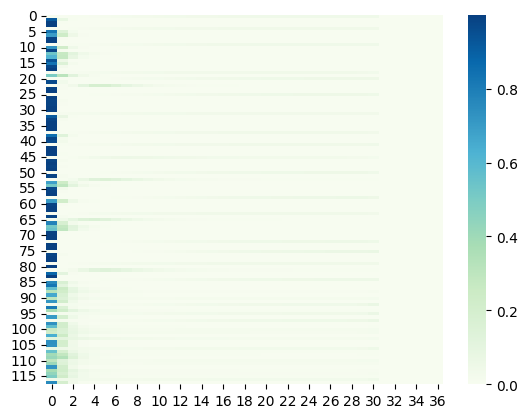

###########VALIDATION########
Prediction String:  و المستوديه اللي هو اللي بيتعامل على المواج اللي هو اللي بيتعامل على ا
Prediction String_len:  70
Labels_string:  كيد لما بياخد إجراء النهارده بهذا بهذه القوه لأن أول مره بنتكلم على
Len_label_string:  67
Prediction String:  و المستوديه اللي هو اللي بيتعامل على المواج اللي هو اللي بيتعامل على ا
Prediction String_len:  70
Labels_string:  لمستوى البشري والإنساني إم ينظر للأشياء بقيمتها مش بتمنها يعني
Len_label_string:  62
Prediction String:  و المستوديه اللي هو اللي بتعمل الموضوع اللي هو اللي بتعمل الموضوع اللي
Prediction String_len:  70
Labels_string:  اح إختبارات نادي الزمالك و هو زملكاوي صرف يعني مش هسأله اقوله كنت أهلاوي و لا زملكاوي لأن أنا عارف إن هو كان زملكاوي صرف
Len_label_string:  120
Prediction String:  و المستوديه اللي هو اللي بيتعامل على المواج اللي هو اللي بيتعامل على ا
Prediction String_len:  70
Labels_string:  عني أنا أنا عايزه أقول حاجه اتفضلي إحنا
Len_label_string:  39
Prediction String:  و المستوديه اللي هو اللي بيتعامل 

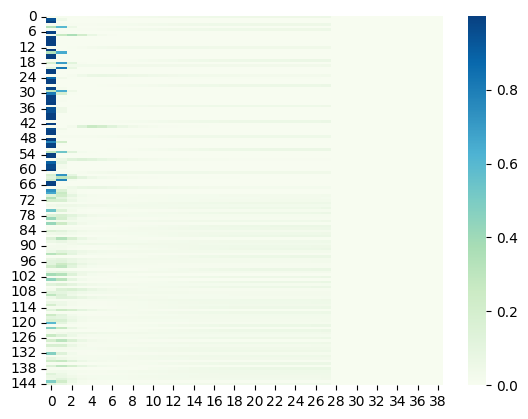

###########  EPOCH: 3  ################
#########  TRAINING  ##########
Learning rate: 0.002
Teacher Forcing: 1 True
Train Loss: tensor(1.7236, device='cuda:0')


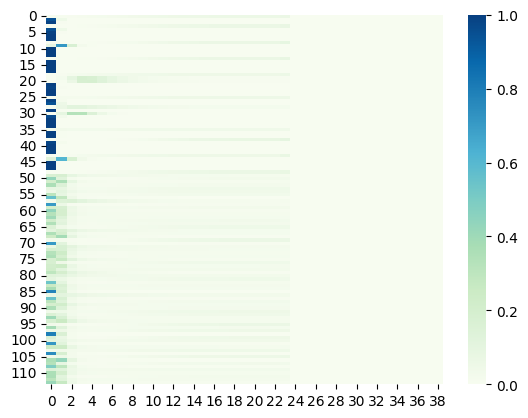

###########VALIDATION########
Prediction String:  و الله يرحمه و لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا ل
Prediction String_len:  70
Labels_string:  ولي وهدان فاز بالجايزه الأولى للسباق
Len_label_string:  36
Prediction String:  و الله يرحمه و لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا ل
Prediction String_len:  70
Labels_string:  و هو بس انت عارف فعلا المشكله زي ما انت بتقول
Len_label_string:  45
Prediction String:  و الله يرحمه و لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا ل
Prediction String_len:  70
Labels_string:  ه أو ده ده الطبيعي يعني ممكن أناقش يعني حاجه سلبيه في المجتمع بس بشكل لائق ما إحنا كنا بنناقش زمان في السبعينات و التمانينات
Len_label_string:  124
Prediction String:  و الله يرحمه و لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا لا ل
Prediction String_len:  70
Labels_string:  ركاء معايا ومسئولين عن ال عن الموضوع ده فإحنا إيد واحده دايما مع بعض
Len_label_string:  68
Prediction String:  و الله يرحمه و لا لا لا لا لا لا لا لا لا لا لا 

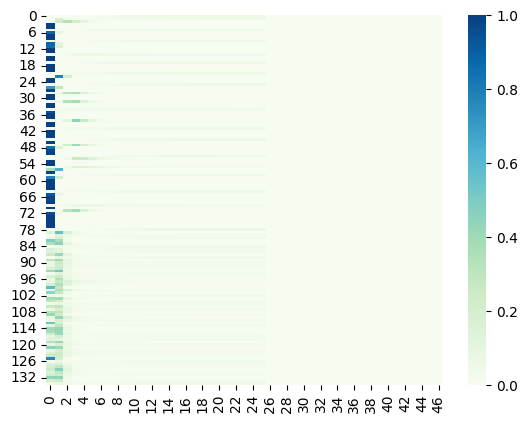

###########  EPOCH: 5  ################
#########  TRAINING  ##########
Learning rate: 0.002
Teacher Forcing: 1 True
Train Loss: tensor(1.6412, device='cuda:0')


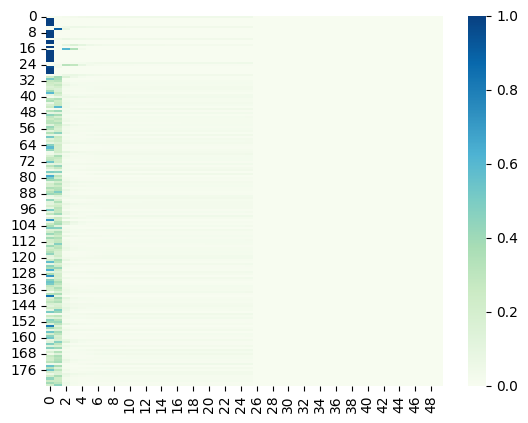

###########VALIDATION########
Prediction String:  و الله العظيم و الله العظيم و الله العظيم و الله العظيم و الله العظيم 
Prediction String_len:  70
Labels_string:  الإضافه الاسترس و التوتر و ده بقى جزء من إيقاع الحياه الحالي اللي احنا بنعيشه إم
Len_label_string:  80
Prediction String:  و الله العظيم و الله العظيم و الله العظيم و الله العظيم و الله العظيم 
Prediction String_len:  70
Labels_string:  ي زياره في الإمارات وراجعه أنا معرفش فنانين الإمارات
Len_label_string:  52
Prediction String:  و الله العظيم و الله العظيم و الله العظيم و الله العظيم و الله العظيم 
Prediction String_len:  70
Labels_string:  ي الصعيد إم عندنا الكلام ده من أيام الفراعنه حرفيا
Len_label_string:  50
Prediction String:  و الله العظيم و الله العظيم و الله العظيم و الله العظيم و الله العظيم 
Prediction String_len:  70
Labels_string:  الحمد لله بننجح في الاخر خلقتي عالم مابيحبش حب الأطفال والتدريس وحب التمثيل عملتي
Len_label_string:  81
Prediction String:  و الله العظيم و الله العظيم و الله العظيم و الله العظيم و ا

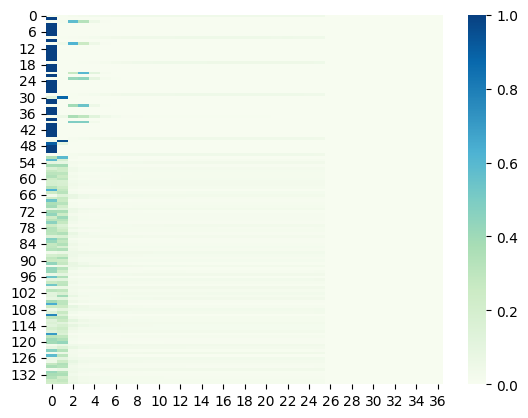

###########  EPOCH: 7  ################
#########  TRAINING  ##########
Learning rate: 0.002
Teacher Forcing: 1 True
Train Loss: tensor(1.6061, device='cuda:0')


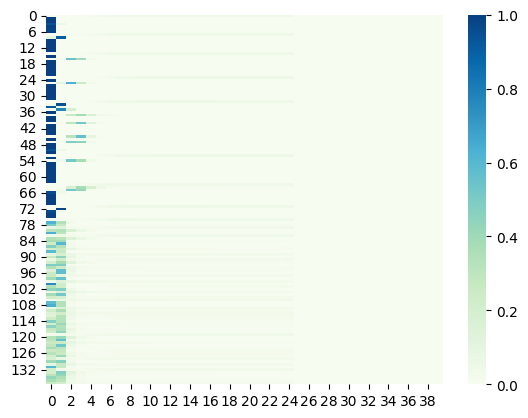

###########VALIDATION########
Prediction String:  و الله يرحمه و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو الل
Prediction String_len:  70
Labels_string:  اصة بقى مع إختلاف بقى المهام عندنا إنه غير مهم و غير عاجل بنضعه في البدايه
Len_label_string:  74
Prediction String:  و الله يرحمه و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو الل
Prediction String_len:  70
Labels_string:  للي هما بقى بيلعبوها وممكن إن هما يصطادوا ناس تانيه يقولوا مثلا لأي واحد تعالى
Len_label_string:  78
Prediction String:  و الله يرحمه و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو الل
Prediction String_len:  70
Labels_string:  يروا حياتك أه أه أه و بعدين لما باجي ملهمش في البيت يعني بيركبوا خمسميت
Len_label_string:  71
Prediction String:  و الله يرحمه و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو الل
Prediction String_len:  70
Labels_string:  ش من الممثلين اللي كان هدفهم أو كانوا نبلاء لدرجة إن لأ مش هدفي إن أنا
Len_label_string:  70
Prediction String:  و الله يرحمه و الله العظيم ال

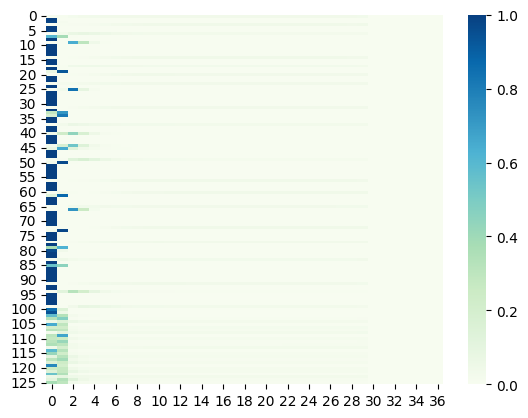

###########  EPOCH: 9  ################
#########  TRAINING  ##########
Learning rate: 0.0018000000000000002
Teacher Forcing: 1 True
Train Loss: tensor(1.5879, device='cuda:0')


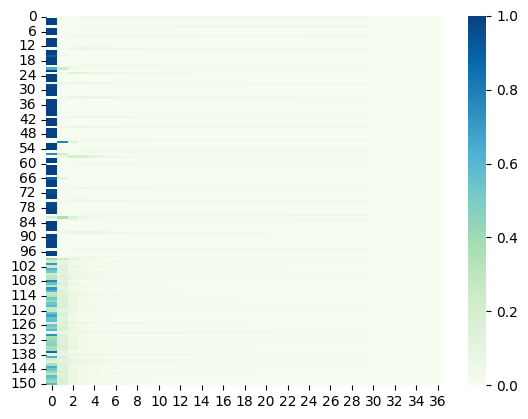

###########VALIDATION########
Prediction String:  و الله يرحمه الله يرحمه الله يرحمه يا رب يا فندم أنا مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  دأت تبقى يعني تبقى عاليه
Len_label_string:  24
Prediction String:  و الله يرحمه الله يرحمه الله يرحمه يا رب يا فندم أنا مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  ساء الخير على كل مشاهدي تسعين دقيقه النهارده حلقه خاصه جدا من تسعين دقيقه حلقه بنحتف
Len_label_string:  84
Prediction String:  و الله يرحمه الله يرحمه الله يرحمه يا رب يا فندم أنا مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  عد الفطار إن الشوارع كلها فاضيه إم فده بيدل إن إحنا فعلا الحركه المروريه
Len_label_string:  72
Prediction String:  و الله يرحمه الله يرحمه الله يرحمه يا رب يا فندم أنا مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  ي أقصد يعني دلوقتي الناس أكيد إبتدت تعرف وشك عارفه إسمك عملتي كذا دور إشتغلتي مع ناس كبيره أوي أه حسيت إن الموضوع ده
Len_label_string:  116
Prediction String:  و الله يرحمه الله يرحمه ا

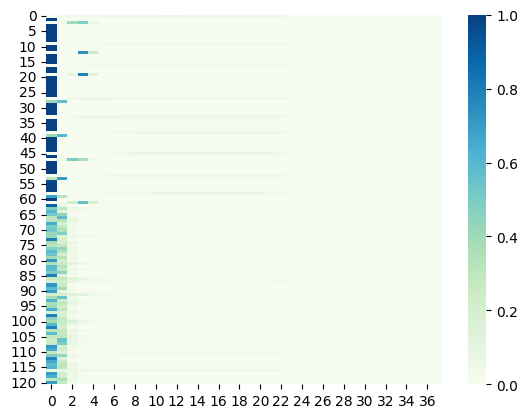

###########  EPOCH: 11  ################
#########  TRAINING  ##########
Learning rate: 0.0018000000000000002
Teacher Forcing: 1 True
Train Loss: tensor(1.5706, device='cuda:0')


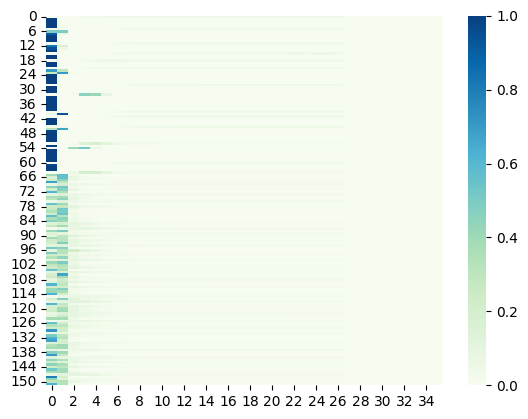

###########VALIDATION########
Prediction String:  و الله العظيم أنا مش عارف إيه أنا مش عارفه إيه أنا مش عارفه إيه أنا مش
Prediction String_len:  70
Labels_string:  ارف أنا برضو ساعات ببقى غيور على مصر يعني مش مجرد حضور رئيس يبقى ده يكبر بلد يعني
Len_label_string:  81
Prediction String:  و الله العظيم أنا مش عارف إيه أنا مش عارفه إيه أنا مش عارفه إيه أنا مش
Prediction String_len:  70
Labels_string:  صطلح لطيف هو الانتقال المرن الانتقال المرن هنا اسمحلي إن انا أعمل دور المحاور المحايد
Len_label_string:  85
Prediction String:  و الله العظيم أنا مش عارف إيه أنا مش عارفه إيه أنا مش عارفه إيه أنا مش
Prediction String_len:  70
Labels_string:  نا كمان بالاخص وائل كمان اكتر علطول بقي معاه أه أه
Len_label_string:  50
Prediction String:  و الله العظيم أنا مش عارف إيه أنا مش عارفه إيه أنا مش عارفه إيه أنا مش
Prediction String_len:  70
Labels_string:  و لأ ده ممثل المكار أو لأ ده ممثل الكوميدي متنفعش تروح
Len_label_string:  54
Prediction String:  و الله العظيم أنا مش عارف إيه أنا مش عارفه إيه أنا م

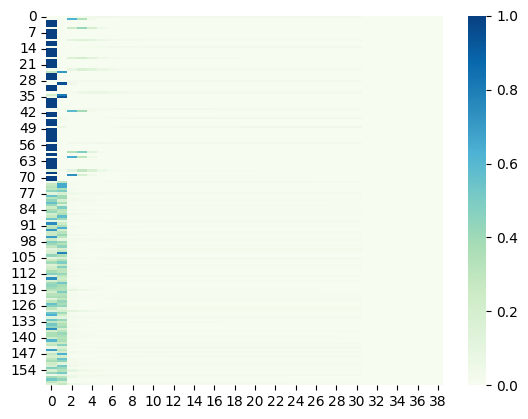

###########  EPOCH: 13  ################
#########  TRAINING  ##########
Learning rate: 0.0016200000000000001
Teacher Forcing: 1 True
Train Loss: tensor(1.5633, device='cuda:0')


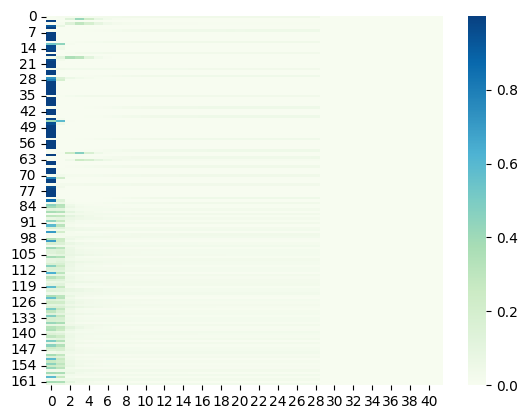

###########VALIDATION########
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string:  هما سافر ومهما بعيد
Len_label_string:  19
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string:  ي بعض الحشرات كل كل ده أساليب دفاع عن النفس أساليب دفاع عن النفس المشروعه بالنسبه للحيوان مشروعه طيب
Len_label_string:  100
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string:  للي شرب منهم خلاصة الخبره الإداريه وسر أسرار النجاح
Len_label_string:  51
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string:  ا مضيعش وقتك أي أكيد إنت مشغول في في حاجات كتير أي ردود الأفعال
Len_label_string:  63
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String

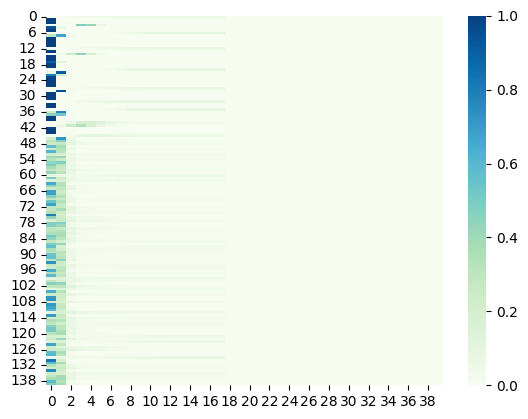

###########  EPOCH: 15  ################
#########  TRAINING  ##########
Learning rate: 0.0016200000000000001
Teacher Forcing: 1 True
Train Loss: tensor(1.5519, device='cuda:0')


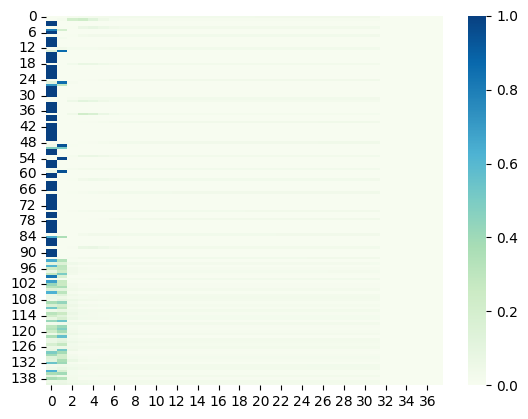

###########VALIDATION########
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string:  س كان إيه لزومه ما الدنيا هديت في ناس كتير أوي من حبايب بيومي فؤاد اللي
Len_label_string:  71
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string:  ايزه أعرف بس الزلط ده كله ده إنت لقيته في الأرض صح
Len_label_string:  50
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string:  ي واحد من البلد طلع في التلفزيون وبيتكلم في الأقتصاد القريه عندك أه أه
Len_label_string:  70
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string:  يره متداخله ومتشابكه
Len_label_string:  20
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string

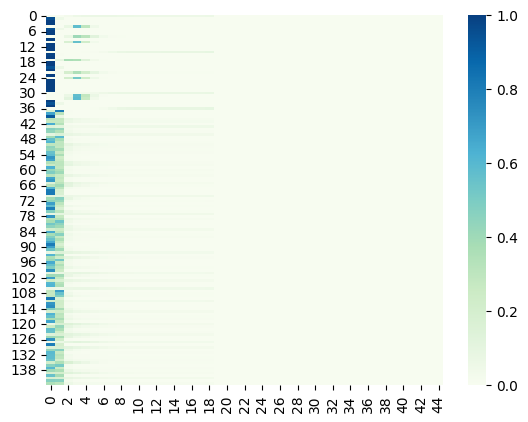

###########  EPOCH: 17  ################
#########  TRAINING  ##########
Learning rate: 0.001458
Teacher Forcing: 1 True
Train Loss: tensor(1.5433, device='cuda:0')


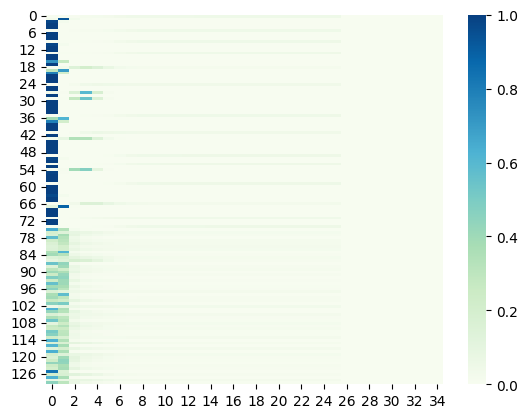

###########VALIDATION########
Prediction String:  و الله العظيم أنا مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش م
Prediction String_len:  70
Labels_string:  يه إنت قولت مع رامز إن صفقة إمام عاشور أفضل مية مره من صفقة عبد الله السعيد عشان خاطر
Len_label_string:  85
Prediction String:  و الله العظيم أنا مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش م
Prediction String_len:  70
Labels_string:  ن أمريكا كلموا البتاع مش عارف ازاي بس تخش دخلنا
Len_label_string:  47
Prediction String:  و الله العظيم أنا مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش م
Prediction String_len:  70
Labels_string:  وم التلات هيبان أكتر اتجاه الدهب في الفتره القادمه
Len_label_string:  50
Prediction String:  و الله العظيم أنا مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش م
Prediction String_len:  70
Labels_string:  ستقصد الرقصات ليه مالك بالراقصات أنا ماليش دعوه إيه التار اللي بينك وبينهم
Len_label_string:  74
Prediction String:  و الله العظيم أنا مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش 

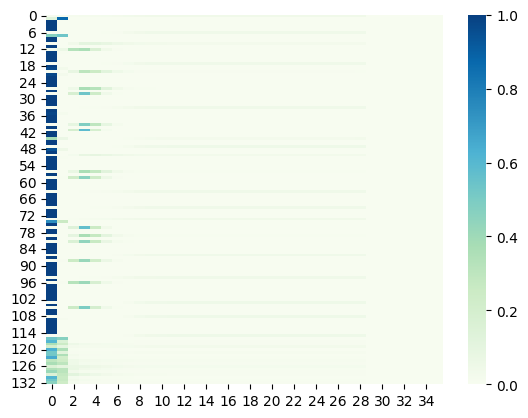

###########  EPOCH: 19  ################
#########  TRAINING  ##########
Learning rate: 0.001458
Teacher Forcing: 1 True
Train Loss: tensor(1.5386, device='cuda:0')


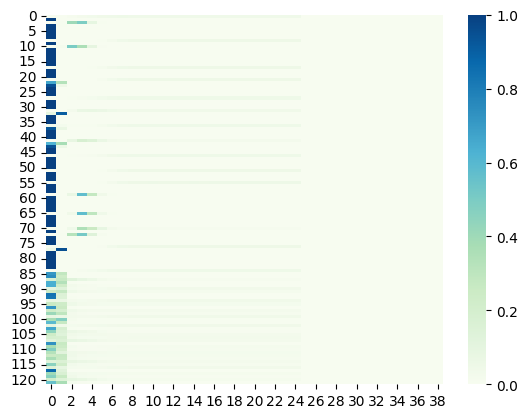

###########VALIDATION########
Prediction String:  و الله العظيم مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  مان يا دكتور أنا كنت قاعده وكنت بستتقل نفسي ومش قادره أقوم أجيب لنفسي حاجه الحمد لله مرضى كتير جدا
Len_label_string:  98
Prediction String:  و الله العظيم مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  لشعب و على الدوله و على الاستثمار طيب
Len_label_string:  37
Prediction String:  و الله العظيم مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  شكره يعني مقدرش أقولك على إن أمه ويعتبري أمه بشكره أحسن شكر واللي جه عملولنا البير واللي شارك حتى في
Len_label_string:  100
Prediction String:  و الله العظيم مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  اص بيا يعني إن هو يبقى عالي تماما قدام يعني
Len_label_string:  43
Prediction String:  و الله العظيم مش مش مش مش مش مش مش مش مش مش

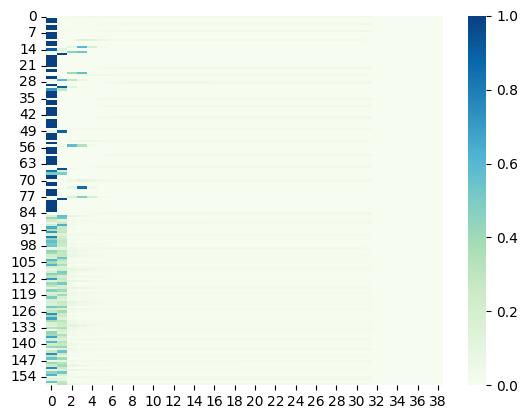

###########  EPOCH: 21  ################
#########  TRAINING  ##########
Learning rate: 0.0013122000000000001
Teacher Forcing: 1 True
Train Loss: tensor(1.5325, device='cuda:0')


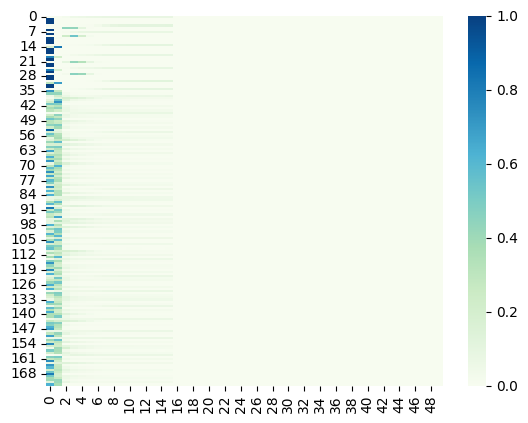

###########VALIDATION########
Prediction String:  و الله العظيم ما هو مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:   استمتعت بيها جدا جدا جدا إنت حضرتك بتتكلم هنا تاريخ نعم
Len_label_string:  56
Prediction String:  و الله العظيم ما هو مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:   بالتالي على الأقل نغير هذا المفهوم و نغير هذا الفكر فالمؤتمر هينفعنا في حاجتين أول حاجه نغير قانون يونسكو تاني حاجه إن إحنا نطالب بحق الملكيه
Len_label_string:  142
Prediction String:  و الله العظيم ما هو مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  نشئت على يد سعيد ديليسبس و أطباق المكرونه اللي أدت إلى هذا
Len_label_string:  58
Prediction String:  و الله العظيم ما هو مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  يفيد البلد هيساعد في زيادة دخل القناه كان محاوله كمان لصناعة الأمل للمصريين
Len_label_string:  75
Prediction

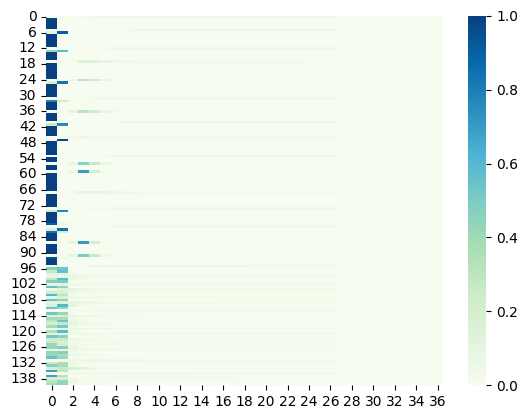

###########  EPOCH: 23  ################
#########  TRAINING  ##########
Learning rate: 0.00118098
Teacher Forcing: 1 True
Train Loss: tensor(1.5287, device='cuda:0')


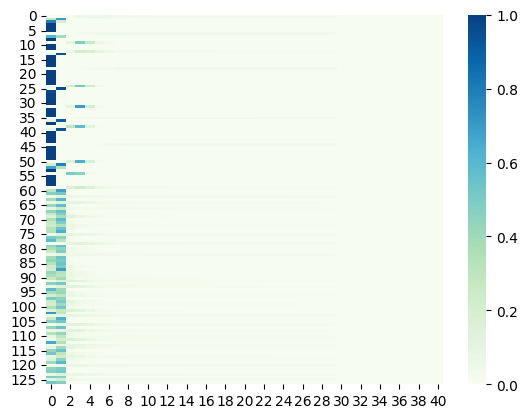

###########VALIDATION########
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string:  تجوز صفيه هانم زغلول صفيه بنت مصطفى فهمي باشا
Len_label_string:  45
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string:  نا هجيبهالك زي ما هي واقفه كده طب إنتي خايفه لا تطلع كده أنا خايفه منطلعش كده
Len_label_string:  77
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string:  ان له كان له تكنيك معين إن هو إعتمد
Len_label_string:  35
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string:  ه إيه سعيد الحظ ده مدافع رمضان أيوه
Len_label_string:  35
Prediction String:  و الله العظيم اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو اللي هو 
Prediction String_len:  70
Labels_string:  ن العصر الحجري ه

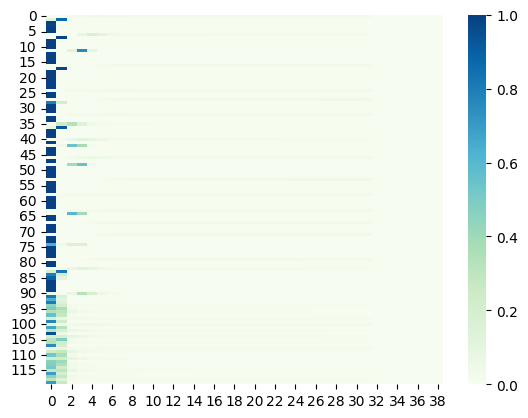

###########  EPOCH: 25  ################
#########  TRAINING  ##########
Learning rate: 0.00118098
Teacher Forcing: 1 True
Train Loss: tensor(1.5235, device='cuda:0')


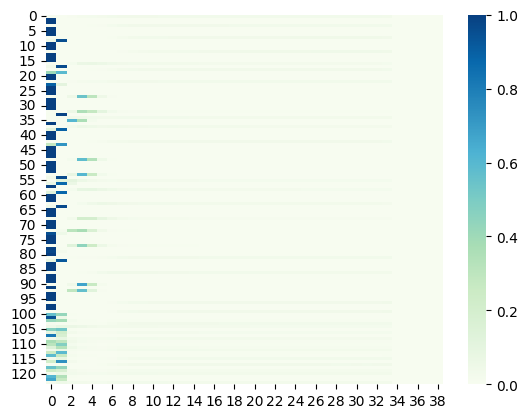

###########VALIDATION########
Prediction String:  و الله العظيم أنا مش عارف إيه و لا مش مش مش مش مش مش مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  لمعدل التضخم في السلة إيه المؤشر نفسه بتاع التضخم اللي هو الأكل و الشرب إم
Len_label_string:  74
Prediction String:  و الله العظيم أنا مش عارف إيه و لا مش مش مش مش مش مش مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  ه أو إن الجلد بيحبب أو فيه نقط أو بطشه حمرا في الجلد أه دي كلها ممكن تكون من أعراض المرض
Len_label_string:  88
Prediction String:  و الله العظيم أنا مش عارف إيه و لا مش مش مش مش مش مش مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  وعى تروحو شمال ويمين وحدوته وأغاني كمان
Len_label_string:  39
Prediction String:  و الله العظيم أنا مش عارف إيه و لا مش مش مش مش مش مش مش مش مش مش مش مش
Prediction String_len:  70
Labels_string:  دخين هو مش إدمان لمده معينه أو للنيكوتين إم على سبيل المثال ولكن هو عاده سيئه إدمان لهذه العاده تمام هو اتعود خلاص
Len_label_string:  114
Prediction String:  و الله

KeyboardInterrupt: 

In [51]:
#SAMPLE
n_epochs = 50

optimizer = optim.Adam(model.parameters(), lr = 0.002) #in paper ASGC(lr = 0.2, geometric_decay = 0.98)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2)# fill this out
criterion = nn.CrossEntropyLoss(reduction='none')
# optimizer = optim.Adam(model.parameters(), lr = 0.002)# fill this out)
# Make sure you understand the implication of setting reduction = 'none'
# criterion = nn.CrossEntropyLoss(reduction='none')
mode = 'train'

teacher_force_rate = 1
# teacher_reduce = (1-0.6)/n_epochs
for epoch in range(n_epochs): #stopped training after epoch 21 to change teacher forcinng rate
    torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    print('###########  EPOCH:',epoch+1,' ################')
    # mode = 'train'
    print('#########  TRAINING  ##########')
    train(model, train_loader, criterion, optimizer, mode = 'train', teacher_forcing = True, teacher_rate =teacher_force_rate,epoch = epoch)
    # teacher_force_rate = teacher_force_rate *0.98
    
    if epoch%2 ==0:
        print('###########VALIDATION########')
        mode = 'eval'
        val(model, val_loader, mode = 'eval') 


# TESTING

In [29]:
torch.cuda.empty_cache()

In [30]:
output = []
model.eval()
final_output = []

for i, (x, x_len) in tqdm(enumerate(test_loader)):
    x = x.cuda()
    predictions, attentions = model(x, x_len, mode='test', y=None, teacher_forcing=False, teacher_rate=0)
    batch_size = predictions.shape[0]

    final_pred = predictions.argmax(-1)

    for i in range(batch_size): 
        h_list = []

        for letter_ind in final_pred[i]:
            if letter_ind.item() == 0:
                continue
            elif letter_ind.item() == 29:
                break
            else:
                h_list.append(letter_ind.item())
        
        h_string = ""
        for x in h_list:
            h_string = h_string + index2letter[x] 
        
        final_output.append(h_string)


16it [01:12,  4.55s/it]


In [33]:
print(final_output[60])

و الله العظيم أنا بقولك إن الموضوع ده مش مش مش مش مش مش مش مش مش مش مش
